In [1]:
train_path = 'data/archive (4)/train.csv'
valid_path = 'data/archive (4)/valid.csv'

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import torch.nn as nn
import torch.nn.functional as F

# Load dataset
data = pd.read_csv(train_path)  
texts = data['paras'].fillna("").tolist()
labels = data['label'].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Load dataset
valid_data = pd.read_csv(train_path)  
valid_texts = valid_data['paras'].fillna("").tolist()
valid_labels = valid_data['label'].tolist()

#Encode valid labels
valid_label_encoder = LabelEncoder()
valid_labels = valid_label_encoder.fit_transform(labels)
# Initialize tokenizer (Use a model that supports Nepali, like multilingual BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


c:\Users\TCS\anaconda3\envs\newtorchenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(label_encoder.classes_)

3

In [4]:
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class NepaliNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create Datasets and DataLoaders
train_dataset = NepaliNewsDataset(texts, labels, tokenizer)
val_dataset = NepaliNewsDataset(valid_texts, valid_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, ff_size, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_size, ff_size),
            nn.ReLU(),
            nn.Linear(ff_size, embed_size)
        )
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward layer
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        
        return x


class CustomTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size=768, num_heads=8, num_layers=6, ff_size=2048, max_len=512):
        super(CustomTransformerEncoder, self).__init__()
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_size))
        
        # Transformer encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_size, num_heads, ff_size) for _ in range(num_layers)
        ])
        
    def forward(self, input_ids):
        # Token embeddings
        token_embeddings = self.embedding(input_ids)
        
        # Add positional encoding
        seq_len = input_ids.size(1)
        embeddings_with_pos = token_embeddings + self.positional_encoding[:, :seq_len, :]
        
        # Pass through the transformer layers
        x = embeddings_with_pos.transpose(0, 1)  # Transpose for multihead attention (seq_len, batch_size, embed_size)
        for layer in self.layers:
            x = layer(x)
        
        return x.transpose(0, 1)  # Transpose back to (batch_size, seq_len, embed_size)


In [9]:
class CustomTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=2, embed_size=768, num_heads=8, num_layers=6, ff_size=2048, max_len=512):
        super(CustomTransformerClassifier, self).__init__()
        
        # Custom Transformer Encoder
        self.encoder = CustomTransformerEncoder(vocab_size, embed_size, num_heads, num_layers, ff_size, max_len)
        
        # Classification head
        self.fc = nn.Linear(embed_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        # Pass the input through the encoder
        encoder_output = self.encoder(input_ids)
        
        # Use the output of the [CLS] token (first token) for classification
        cls_output = encoder_output[:, 0, :]
        
        # Dropout for regularization
        cls_output = self.dropout(cls_output)
        
        # Final classification layer
        logits = self.fc(cls_output)
        
        return logits
model = CustomTransformerClassifier(vocab_size=len(tokenizer), num_classes= len(label_encoder.classes_))


In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

model.train()
losses=[]
# Training loop
for epoch in range(3):  # Adjust epochs as needed
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        # attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.1765
Epoch 2, Loss: 0.1230
Epoch 3, Loss: 0.1113


Install torchinfo for a detailed model summary (pip install torchinfo).
CustomTransformerClassifier(
  (encoder): CustomTransformerEncoder(
    (embedding): Embedding(119547, 768)
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=768, bias=True)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


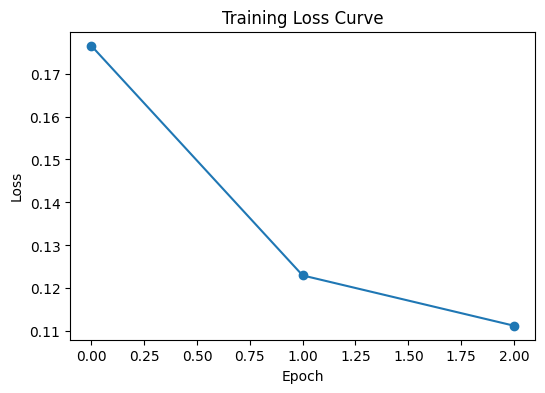

In [14]:
import torch
import matplotlib.pyplot as plt

# Visualize the model architecture using torchinfo (if available)
try:
    from torchinfo import summary
    print("Model Summary:")
    summary(model, input_size=(1, 128), col_names=["input_size", "output_size", "num_params"])
except ImportError:
    print("Install torchinfo for a detailed model summary (pip install torchinfo).")
    print(model)

# Optionally, visualize training loss curve if available
if 'total_loss' in locals():
    # If you have stored loss per epoch, plot it
    if isinstance(losses, list):
        plt.figure(figsize=(6,4))
        plt.plot(losses, marker='o')
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


In [7]:
torch.save(model.state_dict(), "model.pth")

In [8]:
# Evaluation
model.eval()
predictions, ground_truth = [], []
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        # attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())
        # _, predicted = torch.max(outputs, 1)  # Get predicted class

        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

accuracy = accuracy_score(ground_truth, predictions)
print(f"Validation Accuracy: {accuracy:.2f}")


Validation Accuracy: 0.96


In [9]:

test_path = "data/archive (4)/test.csv"
# Load test data
test_data = pd.read_csv(test_path)  # Replace with your test dataset path
test_texts = test_data['paras'].fillna("").tolist()
test_labels = label_encoder.transform(test_data['label'].tolist())  # Ensure labels are encoded similarly

# Prepare test dataset
test_dataset = NepaliNewsDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [10]:
model.eval()  # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictions, ground_truth = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        # attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        # Collect predictions and ground truth
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())


In [11]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate Accuracy
accuracy = accuracy_score(ground_truth, predictions)
print(f"Test Accuracy: {accuracy:.2f}")

# Detailed Classification Report
report = classification_report(ground_truth, predictions, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)


Test Accuracy: 0.96

Classification Report:
                precision    recall  f1-score   support

     business       0.95      0.96      0.96       539
entertainment       0.95      0.94      0.94       466
       sports       0.98      0.98      0.98       491

     accuracy                           0.96      1496
    macro avg       0.96      0.96      0.96      1496
 weighted avg       0.96      0.96      0.96      1496



In [18]:
output_df = pd.DataFrame({
    "Text": test_texts,
    "True Label": label_encoder.inverse_transform(ground_truth),
    "Predicted Label": label_encoder.inverse_transform(predictions)
})
output_df.to_csv("test_predictions.csv", index=False)
print("Predictions saved to 'test_predictions.csv'.")


Predictions saved to 'test_predictions.csv'.
